**Task 1 (70 points):
Part 1 (20 points): This step involves downloading, preparing, and visualizing your
dataset. Create a convolutional base using a common pattern: a stack of Conv and
MaxPooling layers. Depending on the problem and the dataset you must decide what
pattern you want to use (i.e., how many Conv layers and how many pooling layers).
Please describe why you chose a particular pattern. Add the final dense layer(s).
Compile and train the model. Report the final evaluation and describe the metrics.**

Problem statement: Classifying a grapevine leave.\
Dataset: https://www.muratkoklu.com/datasets/


In [23]:
import pandas as pd
import random
from pathlib import Path
import tensorflow as tf
from shutil import copy2
from shutil import copyfile
from google.colab import drive
from keras.layers import Dense, Flatten, Conv2D, Dropout,MaxPool2D, LSTM, BatchNormalization
import plotly.express as px
import matplotlib.pyplot as plt
from plotly.offline import init_notebook_mode, iplot
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.preprocessing import Normalizer
from sklearn.utils import shuffle
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score
from keras.utils.np_utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from numpy import std
import os
import cv2
import warnings
warnings.filterwarnings("ignore")

drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
parent_dir = Path('drive/My Drive/ML/Hw5/Grapevine_Leaves_Image_Dataset')
grapevine_classes = ["Ak","Ala_Idris","Buzgulu","Dimnit","Nazli"]

Ak = [fn for fn in os.listdir(f'{parent_dir}/Ak') if fn.endswith('.png')]
Ala_Idris = [fn for fn in os.listdir(f'{parent_dir}/Ala_Idris') if fn.endswith('.png')]
Buzgulu = [fn for fn in os.listdir(f'{parent_dir}/Buzgulu') if fn.endswith('.png')]
Dimnit = [fn for fn in os.listdir(f'{parent_dir}/Dimnit') if fn.endswith('.png')]
Nazli = [fn for fn in os.listdir(f'{parent_dir}/Nazli') if fn.endswith('.png')]
all = [Ak,Ala_Idris,Buzgulu,Dimnit,Nazli]

training_dir_path=[f'drive/My Drive/ML/Hw5/Grapevine_Leaves_Image_Dataset/training/{a}' for a in grapevine_classes]
validation_dir_path=[f'drive/My Drive/ML/Hw5/Grapevine_Leaves_Image_Dataset/validation/{a}' for a in grapevine_classes]
testing_dir_path=[f'drive/My Drive/ML/Hw5/Grapevine_Leaves_Image_Dataset/testing/{a}' for a in grapevine_classes]
source_path=[f'drive/My Drive/ML/Hw5/Grapevine_Leaves_Image_Dataset/{a}' for a in grapevine_classes]

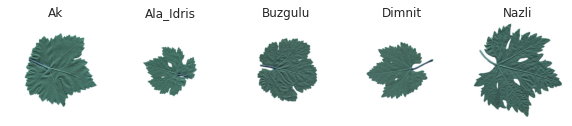

In [118]:
plt.figure(figsize=(10,10))
i=0
for label in grapevine_classes:
    i+=1
    plt.subplot(1, 5, i)
    file = random.choice(os.listdir(f'{parent_dir}/{label}'))
    image_path = os.path.join(f'{parent_dir}/{label}', file)
    img=cv2.imread(image_path)
    plt.title(label)
    plt.imshow(img)
    plt.grid(None)
    plt.axis('off')

Total images: 500
Total class: 5


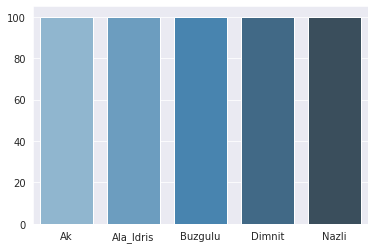

In [119]:
total = 0
for i in all:
  for j in i:
    total+=1

print("Total images: {}".format(total))
print("Total class: 5")

count = []
for i in range(len(grapevine_classes)):
  count.append(len(all[i]))
sns.set_style('darkgrid')
sns.barplot(x=grapevine_classes, y=count, palette="Blues_d")
plt.show()

Image dimensions: (511, 511, 3)


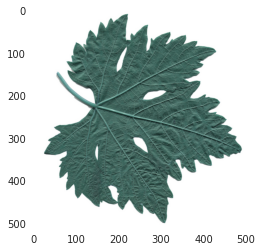

In [120]:
sample_img = cv2.imread(image_path)
plt.imshow(sample_img)
plt.grid(None)
print(f'Image dimensions: {sample_img.shape}')

In [22]:
# os.mkdir('drive/My Drive/ML/Hw5/Grapevine_Leaves_Image_Dataset/training')
# os.mkdir('drive/My Drive/ML/Hw5/Grapevine_Leaves_Image_Dataset/validation')
# os.mkdir('drive/My Drive/ML/Hw5/Grapevine_Leaves_Image_Dataset/testing')

def split_data(SOURCE, TRAINING, VALIDATION, TESTING, SPLIT_SIZE):
  files = []
  #print(SOURCE)
  for filename in os.listdir(SOURCE):
       
        file = SOURCE +'/'+ filename
        if os.path.getsize(file) > 0:
            files.append(filename)

  training_length = int( len(files)* SPLIT_SIZE)
  validation_length = int(len(files) * 0.10)
  testing_length = int(len(files) - training_length - validation_length)
  
  shuffled_set = random.sample(files, len(files))
  training_set = shuffled_set[0:training_length]
  validation_set = shuffled_set[training_length:(training_length+validation_length)]
  testing_set=shuffled_set[:testing_length]
    
  for filename in training_set:
      this_file = SOURCE +'/'+ filename
      destination = TRAINING +'/'+ filename
      copyfile(this_file, destination)

  for filename in testing_set:
      this_file = SOURCE+'/'+filename
      destination =  TESTING+'/'+ filename
      copyfile(this_file, destination)
      
  for filename in validation_set:
      this_file = SOURCE +'/'+ filename
      destination = VALIDATION +'/' + filename
      copyfile(this_file, destination)


split_size = 0.85

   

In [ ]:
for source,train_dir_path,val_dir_path,test_dir_path in zip(source_path,\
                                training_dir_path,validation_dir_path, testing_dir_path):
   
    split_data(source,train_dir_path,val_dir_path,test_dir_path, split_size)

In [4]:
datagen = ImageDataGenerator(rescale=1./255)
train_ds = datagen.flow_from_directory(
    'drive/My Drive/ML/Hw5/Grapevine_Leaves_Image_Dataset/training',
    target_size = (64,64),
    batch_size = 64,
    class_mode='categorical',
    shuffle = True)

val_ds = datagen.flow_from_directory(
    'drive/My Drive/ML/Hw5/Grapevine_Leaves_Image_Dataset/validation',
    target_size = (64, 64),
    batch_size = 64,
    class_mode='categorical',
    shuffle=True)

test_ds = datagen.flow_from_directory(
    'drive/My Drive/ML/Hw5/Grapevine_Leaves_Image_Dataset/testing',
    target_size = (64, 64),
    batch_size = 64,
    class_mode='categorical',
    shuffle=True)


train_ds2 = datagen.flow_from_directory(
    'drive/My Drive/ML/Hw5/Grapevine_Leaves_Image_Dataset/training',
    target_size = (511,511),
    batch_size = 64,
    class_mode='categorical',
    shuffle = True)

val_ds2 = datagen.flow_from_directory(
    'drive/My Drive/ML/Hw5/Grapevine_Leaves_Image_Dataset/validation',
    target_size = (511, 511),
    batch_size = 64,
    class_mode='categorical',
    shuffle=True)

test_ds2 = datagen.flow_from_directory(
    'drive/My Drive/ML/Hw5/Grapevine_Leaves_Image_Dataset/testing',
    target_size = (511, 511),
    batch_size = 64,
    class_mode='categorical',
    shuffle=True)


Found 425 images belonging to 5 classes.
Found 50 images belonging to 5 classes.
Found 25 images belonging to 5 classes.
Found 425 images belonging to 5 classes.
Found 50 images belonging to 5 classes.
Found 25 images belonging to 5 classes.


In [5]:
#implementation of CNN
model = tf.keras.Sequential()   
model.add(tf.keras.layers.Lambda(lambda x: x, input_shape=(64,64, 3)))

model.add(Conv2D(filters = 32, kernel_size = (3,3),activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(2,2))
model.add(Dropout(0.2))

model.add(Conv2D(filters = 64,  kernel_size = (3,3), activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(2,2))
model.add(Dropout(0.2))

model.add(Conv2D(filters= 128,  kernel_size = (3,3),activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(2,2))
model.add(Dropout(0.2))

#dense layers
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(512, activation="relu")) 
model.add(BatchNormalization())
model.add(tf.keras.layers.Dense(512, activation="relu")) 
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(tf.keras.layers.Dense(5, activation="softmax")) 

In [52]:
model.compile(optimizer='adam', loss='categorical_crossentropy',
              metrics=['accuracy'])

model_fit = model.fit(train_ds, validation_data = val_ds, epochs=15, batch_size=64)


Epoch 1/15
7/7 [==============================] - 6s 725ms/step - loss: 0.3193 - accuracy: 0.9012 - val_loss: 17.5108 - val_accuracy: 0.2000
Epoch 2/15
7/7 [==============================] - 5s 634ms/step - loss: 0.3999 - accuracy: 0.8518 - val_loss: 19.2862 - val_accuracy: 0.2000
Epoch 3/15
7/7 [==============================] - 5s 630ms/step - loss: 0.3232 - accuracy: 0.8871 - val_loss: 18.8452 - val_accuracy: 0.2000
Epoch 4/15
7/7 [==============================] - 5s 658ms/step - loss: 0.2987 - accuracy: 0.9082 - val_loss: 20.0202 - val_accuracy: 0.2000
Epoch 5/15
7/7 [==============================] - 5s 653ms/step - loss: 0.2184 - accuracy: 0.9247 - val_loss: 20.5964 - val_accuracy: 0.2000
Epoch 6/15
7/7 [==============================] - 5s 632ms/step - loss: 0.1979 - accuracy: 0.9506 - val_loss: 23.5318 - val_accuracy: 0.2000
Epoch 7/15
7/7 [==============================] - 5s 645ms/step - loss: 0.1425 - accuracy: 0.9576 - val_loss: 26.7655 - val_accuracy: 0.2000
Epoch 8/15
7/

There are 3 convolutional and pooling layers in my model. There's a dropout layer following each pooling layer because I want to prevent the problem of overfitting. However, it seems it's not very helpful because the validation accuracy is low. I choose relu activation as my activation function because the variables can interact with each other in this activation. I doubled the size of filter on each convolutional layer, because I want to extract more features from images. The kernel size for each convolutioanl layer is 3x3 because I want to limiting the number of unrelated features possible. I also used batch normalization to normalize the contributions to a layer for every mini-batch.\
For the last output layer, I choose softmax activation with 5 neurons because there are 5 classes of grapevine leave in my dataset, the softmax activation can normalize the output of a network to a probability distribution over predicted output. For the loss function, I used categorial cross entropy because it can measure the performance of a multi-class classification model. I used mini-batch to train my model because it has stable convergence.\
I used Adam as my optimizer because it's more efficient than other optimizer in my data. It's like the combination of momentum and RMSP method. It uses the squared gradients to scale the learning rate and uses moving average of the gradient. Thus, It's good with sparse data, most consistent convergence, and it has faster computation time.

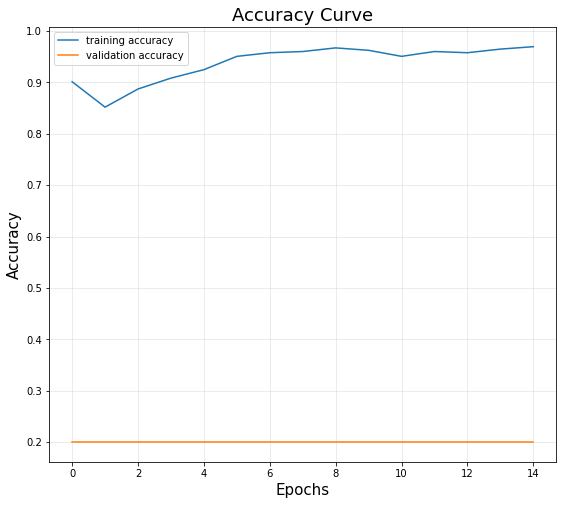

In [53]:
#create the accuracy curve graph
graph = plt.figure(figsize=(20,8))
graph.add_subplot(121)

plt.plot(model_fit.epoch,model_fit.history['accuracy'],label = "training accuracy") # Accuracy curve for training set
plt.plot(model_fit.epoch,model_fit.history['val_accuracy'],label = "validation accuracy")

plt.title("Accuracy Curve",fontsize=18)
plt.xlabel("Epochs",fontsize=15)
plt.ylabel("Accuracy",fontsize=15)
plt.grid(alpha=0.3)
plt.legend()

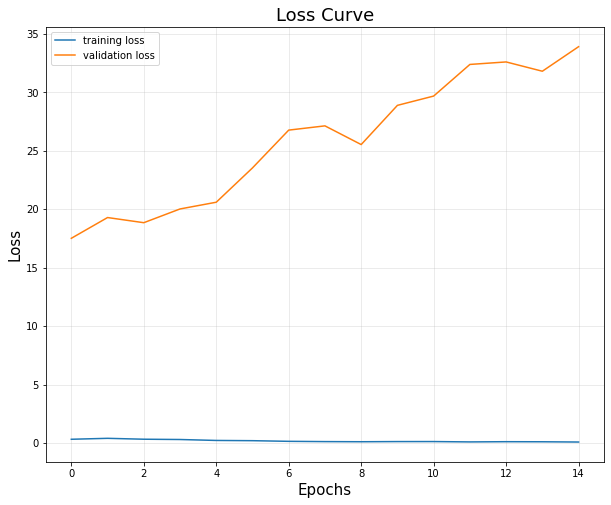

In [54]:
#create the loss graph
graph2 = plt.figure(figsize=(10,8))
graph.add_subplot(121)

plt.plot(model_fit.epoch,model_fit.history['loss'],label="training loss") # Loss curve for training set
plt.plot(model_fit.epoch,model_fit.history['val_loss'],label="validation loss")

plt.title("Loss Curve",fontsize=18)
plt.xlabel("Epochs",fontsize=15)
plt.ylabel("Loss",fontsize=15)
plt.grid(alpha=0.3)
plt.legend()

plt.show()

**Part 2 (25 points): The following models are widely used for transfer learning because of their performance and architectural innovations:**
1. VGG (e.g., VGG16 or VGG19).
2. GoogLeNet (e.g., InceptionV3).
3. Residual Network (e.g., ResNet50).
4. MobileNet (e.g., MobileNetV2)
**Choose any one of the above models to perform the classification task you did in Part 1. Evaluate the results using the same metrics as in Part 1. Are there any differences? Why or why not?**

In [4]:
#Implement GoogLeNet
InceptionV3_model = tf.keras.applications.InceptionV3(weights='imagenet', include_top=False, input_shape=(511, 511, 3))

for layer in InceptionV3_model.layers[:-15]:
    layer.trainable = False

x = InceptionV3_model.output
x =tf.keras.layers.GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(units=512, activation='relu')(x)
x = Dropout(0.2)(x)
x = BatchNormalization()(x)
x = tf.keras.layers.Dense(units=512, activation='relu')(x)
x = Dropout(0.2)(x)
x = BatchNormalization()(x)
output  = tf.keras.layers.Dense(units=5, activation='softmax')(x)
model2 = tf.keras.Model(InceptionV3_model.input, output)

model2.compile(optimizer='adam', loss='categorical_crossentropy',
              metrics=['accuracy'])


In [8]:
model_fit2 = model2.fit(train_ds2, validation_data = val_ds2, epochs=10, batch_size=64)

Epoch 1/10
7/7 [==============================] - 273s 36s/step - loss: 1.0628 - accuracy: 0.6259 - val_loss: 1.2833 - val_accuracy: 0.3600
Epoch 2/10
7/7 [==============================] - 246s 36s/step - loss: 0.1632 - accuracy: 0.9412 - val_loss: 1.1825 - val_accuracy: 0.5200
Epoch 3/10
7/7 [==============================] - 252s 36s/step - loss: 0.0821 - accuracy: 0.9788 - val_loss: 1.0733 - val_accuracy: 0.5800
Epoch 4/10
7/7 [==============================] - 250s 38s/step - loss: 0.0332 - accuracy: 0.9976 - val_loss: 1.0058 - val_accuracy: 0.5400
Epoch 5/10
7/7 [==============================] - 256s 37s/step - loss: 0.0214 - accuracy: 0.9976 - val_loss: 0.9460 - val_accuracy: 0.5600
Epoch 6/10
7/7 [==============================] - 253s 36s/step - loss: 0.0199 - accuracy: 1.0000 - val_loss: 0.9008 - val_accuracy: 0.6000
Epoch 7/10
7/7 [==============================] - 259s 37s/step - loss: 0.0141 - accuracy: 0.9976 - val_loss: 0.8543 - val_accuracy: 0.7000
Epoch 8/10
7/7 [====

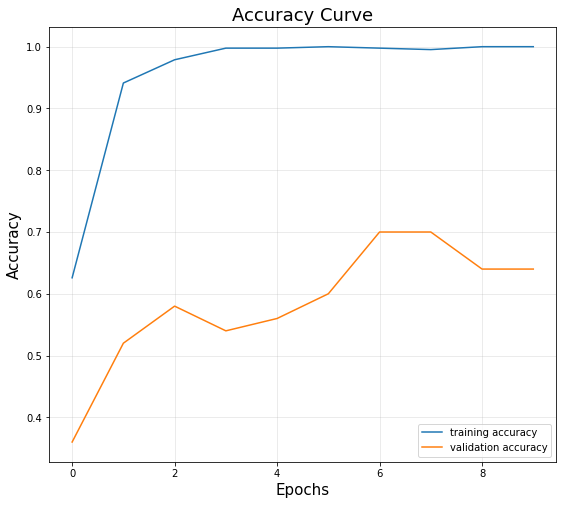

In [10]:
#create the accuracy curve graph
graph = plt.figure(figsize=(20,8))
graph.add_subplot(121)

plt.plot(model_fit2.epoch,model_fit2.history['accuracy'],label = "training accuracy") # Accuracy curve for training set
plt.plot(model_fit2.epoch,model_fit2.history['val_accuracy'],label = "validation accuracy")

plt.title("Accuracy Curve",fontsize=18)
plt.xlabel("Epochs",fontsize=15)
plt.ylabel("Accuracy",fontsize=15)
plt.grid(alpha=0.3)
plt.legend()

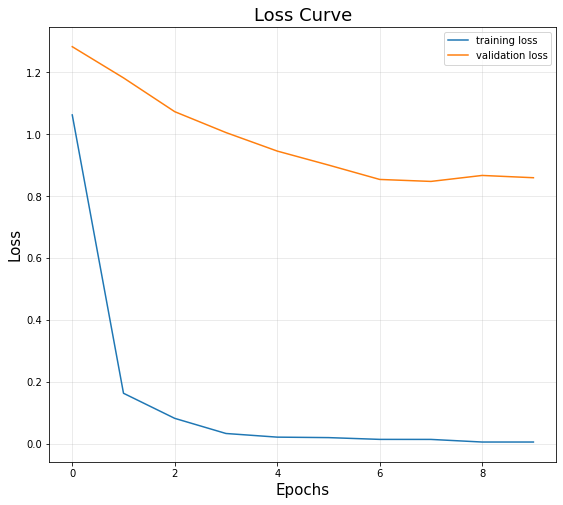

In [13]:
#create the loss graph
graph2 = plt.figure(figsize=(20,8))
graph2.add_subplot(121)

plt.plot(model_fit2.epoch,model_fit2.history['loss'],label="training loss") # Loss curve for training set
plt.plot(model_fit2.epoch,model_fit2.history['val_loss'],label="validation loss")

plt.title("Loss Curve",fontsize=18)
plt.xlabel("Epochs",fontsize=15)
plt.ylabel("Loss",fontsize=15)
plt.grid(alpha=0.3)
plt.legend()

plt.show()

Compare to CNN model, the InceptionV3 model have higher accuracy in both training and validation dataset. Also, the loss is increasing over the time, which means it's more efficient than the CNN model. This is due to the structure of InceptionV3 model. The InceptionV3 model have different inception block. It's performing multiple convolutions in the tensor, it's making improvement based on previous architecture.

**Part 3 (25 points): Use data augmentation to increase the diversity of your dataset by
applying random transformations such as image rotation (you can use any other
technique as well). Repeat the process from part 1 with this augmented data. Did you
observe any difference in results?**

In [61]:
train_datagen = ImageDataGenerator(rescale=1.0/255.,
                                    rotation_range=60,
                                width_shift_range=0.4,
                                 height_shift_range=0.4,
                                  vertical_flip=True,
                                   zoom_range=3,
                                  brightness_range=[0.5,2]
                                   ) 


train2 = train_datagen.flow_from_directory(directory= 'drive/My Drive/ML/Hw5/Grapevine_Leaves_Image_Dataset/training',
                                                      batch_size=128,
                                                      class_mode='categorical',
                                                      target_size=(64, 64)
                                                       )

validation_datagen = ImageDataGenerator(rescale=1.0/255.,
                                    rotation_range=60,
                                 width_shift_range=0.4,
                               height_shift_range=0.4,
                                  vertical_flip=True,
                                   zoom_range=3 ,
                                  brightness_range=[0.5,2]
                                   ) 


validation2 = validation_datagen.flow_from_directory(directory='drive/My Drive/ML/Hw5/Grapevine_Leaves_Image_Dataset/validation',
                                                                batch_size=128,
                                                                class_mode='categorical',
                                                                target_size=(64, 64)
                                                             )

Found 425 images belonging to 5 classes.
Found 50 images belonging to 5 classes.


In [30]:
model.compile(optimizer='adam', loss='categorical_crossentropy',
              metrics=['accuracy'])

model_fit3 = model.fit(train2, validation_data = validation2, epochs=15, batch_size=64)

Epoch 1/15
4/4 [==============================] - 11s 2s/step - loss: 0.9899 - accuracy: 0.6188 - val_loss: 3.3758 - val_accuracy: 0.2400
Epoch 2/15
4/4 [==============================] - 8s 2s/step - loss: 0.9606 - accuracy: 0.6212 - val_loss: 2.5858 - val_accuracy: 0.4000
Epoch 3/15
4/4 [==============================] - 8s 2s/step - loss: 0.9010 - accuracy: 0.6471 - val_loss: 4.1874 - val_accuracy: 0.2600
Epoch 4/15
4/4 [==============================] - 11s 3s/step - loss: 0.9628 - accuracy: 0.6141 - val_loss: 2.5034 - val_accuracy: 0.3800
Epoch 5/15
4/4 [==============================] - 10s 2s/step - loss: 0.9656 - accuracy: 0.6188 - val_loss: 2.1624 - val_accuracy: 0.4000
Epoch 6/15
4/4 [==============================] - 8s 2s/step - loss: 0.8865 - accuracy: 0.6588 - val_loss: 1.7026 - val_accuracy: 0.5000
Epoch 7/15
4/4 [==============================] - 9s 2s/step - loss: 0.8299 - accuracy: 0.6541 - val_loss: 1.8170 - val_accuracy: 0.3600
Epoch 8/15
4/4 [======================

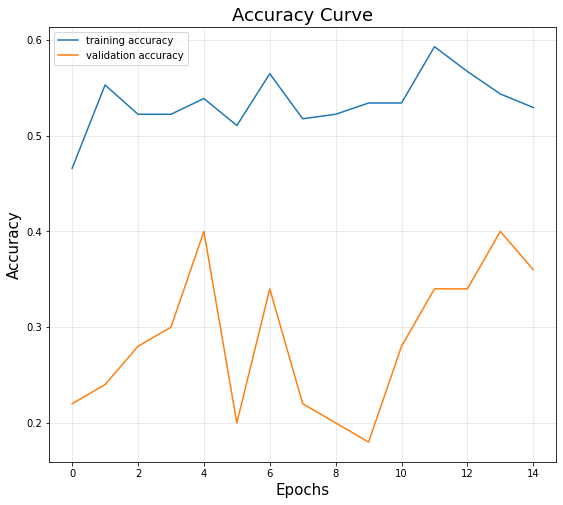

In [63]:
#create the accuracy curve graph
graph = plt.figure(figsize=(20,8))
graph.add_subplot(121)

plt.plot(model_fit3.epoch,model_fit3.history['accuracy'],label = "training accuracy") # Accuracy curve for training set
plt.plot(model_fit3.epoch,model_fit3.history['val_accuracy'],label = "validation accuracy")

plt.title("Accuracy Curve",fontsize=18)
plt.xlabel("Epochs",fontsize=15)
plt.ylabel("Accuracy",fontsize=15)
plt.grid(alpha=0.3)
plt.legend()

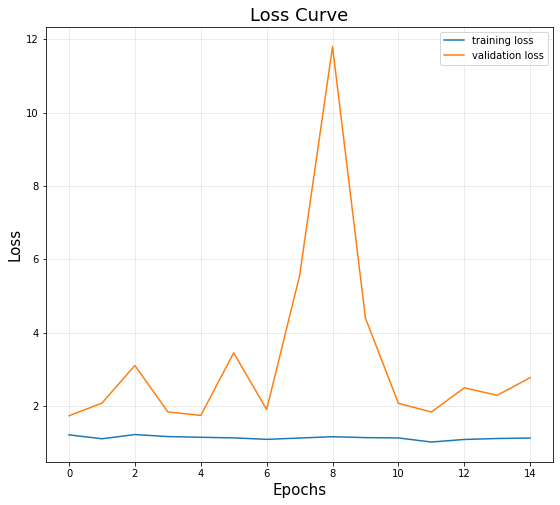

In [65]:
#create the loss graph
graph2 = plt.figure(figsize=(20,8))
graph2.add_subplot(121)

plt.plot(model_fit3.epoch,model_fit3.history['loss'],label="training loss") # Loss curve for training set
plt.plot(model_fit3.epoch,model_fit3.history['val_loss'],label="validation loss")

plt.title("Loss Curve",fontsize=18)
plt.xlabel("Epochs",fontsize=15)
plt.ylabel("Loss",fontsize=15)
plt.grid(alpha=0.3)
plt.legend()

plt.show()

As we can see with data augmentation, the validation accuracy is significantly higher than the model without data augmentation. However, the accuracy for the training data set is significantly lower because the data augmentation is creating more example of training dataset.

**Part 1 (15 points): Variational Autoencoder (VAE): Here is a complete implementation
of a VAE in TensorFlow: https://www.tensorflow.org/tutorials/generative/cvae**

dataset: https://keras.io/api/datasets/fashion_mnist/

In [24]:
from IPython import display
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import tensorflow_probability as tfp
import time
import keras 

In [44]:
(train_images, _), (test_images, _) = tf.keras.datasets.fashion_mnist.load_data()

4422102/4422102 [==============================] - 0s 0us/step


In [45]:
def preprocess_images(images):
  images = images.reshape((images.shape[0], 28, 28, 1)) / 255.
  return np.where(images > .5, 1.0, 0.0).astype('float32')

train_images = preprocess_images(train_images)
test_images = preprocess_images(test_images)

In [46]:
train_size = 60000
batch_size = 32
test_size = 10000

In [47]:
train_dataset = (tf.data.Dataset.from_tensor_slices(train_images)
                 .shuffle(train_size).batch(batch_size))
test_dataset = (tf.data.Dataset.from_tensor_slices(test_images)
                .shuffle(test_size).batch(batch_size))

In [48]:
#from website
class CVAE(tf.keras.Model):
  """Convolutional variational autoencoder."""

  def __init__(self, latent_dim):
    super(CVAE, self).__init__()
    self.latent_dim = latent_dim
    self.encoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(28, 28, 1)),
            tf.keras.layers.Conv2D(
                filters=32, kernel_size=3, strides=(2, 2), activation='relu'),
            tf.keras.layers.Conv2D(
                filters=64, kernel_size=3, strides=(2, 2), activation='relu'),
            tf.keras.layers.Flatten(),
            # No activation
            tf.keras.layers.Dense(latent_dim + latent_dim),
        ]
    )

    self.decoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
            tf.keras.layers.Dense(units=7*7*32, activation=tf.nn.relu),
            tf.keras.layers.Reshape(target_shape=(7, 7, 32)),
            tf.keras.layers.Conv2DTranspose(
                filters=64, kernel_size=3, strides=2, padding='same',
                activation='relu'),
            tf.keras.layers.Conv2DTranspose(
                filters=32, kernel_size=3, strides=2, padding='same',
                activation='relu'),
            # No activation
            tf.keras.layers.Conv2DTranspose(
                filters=1, kernel_size=3, strides=1, padding='same'),
        ]
    )

  @tf.function
  def sample(self, eps=None):
    if eps is None:
      eps = tf.random.normal(shape=(100, self.latent_dim))
    return self.decode(eps, apply_sigmoid=True)

  def encode(self, x):
    mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
    return mean, logvar

  def reparameterize(self, mean, logvar):
    eps = tf.random.normal(shape=mean.shape)
    return eps * tf.exp(logvar * .5) + mean

  def decode(self, z, apply_sigmoid=False):
    logits = self.decoder(z)
    if apply_sigmoid:
      probs = tf.sigmoid(logits)
      return probs
    return logits

In [49]:
optimizer = tf.keras.optimizers.Adam(1e-4)
def log_normal_pdf(sample, mean, logvar, raxis=1):
  log2pi = tf.math.log(2. * np.pi)
  return tf.reduce_sum(
      -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
      axis=raxis)


def compute_loss(model, x):
  mean, logvar = model.encode(x)
  z = model.reparameterize(mean, logvar)
  x_logit = model.decode(z)
  cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
  logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
  logpz = log_normal_pdf(z, 0., 0.)
  logqz_x = log_normal_pdf(z, mean, logvar)
  return -tf.reduce_mean(logpx_z + logpz - logqz_x)


@tf.function
def train_step(model, x, optimizer):
  """Executes one training step and returns the loss.

  This function computes the loss and gradients, and uses the latter to
  update the model's parameters.
  """
  with tf.GradientTape() as tape:
    loss = compute_loss(model, x)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

In [50]:
epochs = 10
# set the dimensionality of the latent space to a plane for visualization later
latent_dim = 2
num_examples_to_generate = 16

# keeping the random vector constant for generation (prediction) so
# it will be easier to see the improvement.
random_vector_for_generation = tf.random.normal(
    shape=[num_examples_to_generate, latent_dim])
model = CVAE(latent_dim)

In [51]:
def generate_and_save_images(model, epoch, test_sample):
  mean, logvar = model.encode(test_sample)
  z = model.reparameterize(mean, logvar)
  predictions = model.sample(z)
  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
    plt.subplot(4, 4, i + 1)
    plt.imshow(predictions[i, :, :, 0], cmap='gray')
    plt.axis('off')

  # tight_layout minimizes the overlap between 2 sub-plots
  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [52]:
# Pick a sample of the test set for generating output images
assert batch_size >= num_examples_to_generate
for test_batch in test_dataset.take(1):
  test_sample = test_batch[0:num_examples_to_generate, :, :, :]

Epoch: 10, Test set ELBO: -192.6836700439453, time elapse for current epoch: 111.3428840637207


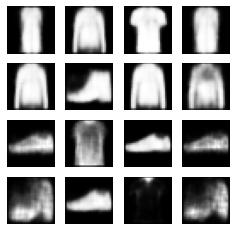

In [53]:
generate_and_save_images(model, 0, test_sample)

for epoch in range(1, epochs + 1):
  start_time = time.time()
  for train_x in train_dataset:
    train_step(model, train_x, optimizer)
  end_time = time.time()

  loss = tf.keras.metrics.Mean()
  for test_x in test_dataset:
    loss(compute_loss(model, test_x))
  elbo = -loss.result()
  display.clear_output(wait=False)
  print('Epoch: {}, Test set ELBO: {}, time elapse for current epoch: {}'
        .format(epoch, elbo, end_time - start_time))
  generate_and_save_images(model, epoch, test_sample)

In [54]:
anim_file = 'cvae.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)


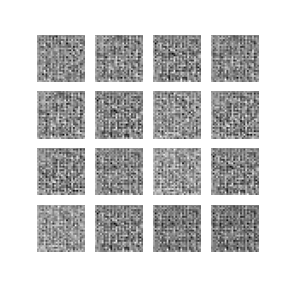

In [57]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)

In [58]:
def plot_latent_images(model, n, digit_size=28):
  """Plots n x n digit images decoded from the latent space."""

  norm = tfp.distributions.Normal(0, 1)
  grid_x = norm.quantile(np.linspace(0.05, 0.95, n))
  grid_y = norm.quantile(np.linspace(0.05, 0.95, n))
  image_width = digit_size*n
  image_height = image_width
  image = np.zeros((image_height, image_width))

  for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
      z = np.array([[xi, yi]])
      x_decoded = model.sample(z)
      digit = tf.reshape(x_decoded[0], (digit_size, digit_size))
      image[i * digit_size: (i + 1) * digit_size,
            j * digit_size: (j + 1) * digit_size] = digit.numpy()

  plt.figure(figsize=(10, 10))
  plt.imshow(image, cmap='Greys_r')
  plt.axis('Off')
  plt.show()

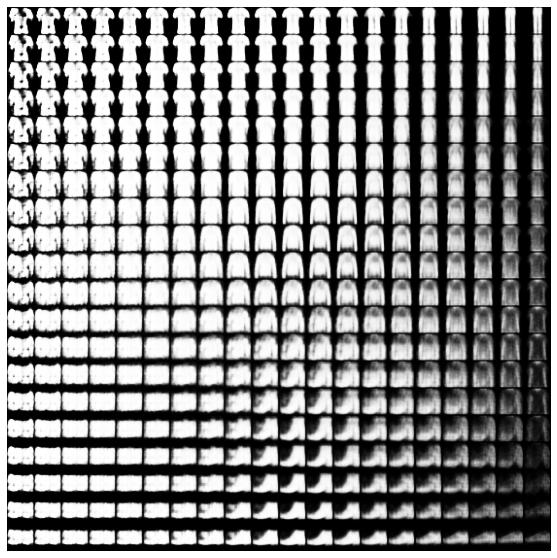

In [59]:
plot_latent_images(model, 20)

**Part 2 (15 points): Generative Adversarial Networks (GANs): Repeat part 1 (use same
dataset) and implement a GAN model to generate high quality synthetic images. You may
follow steps outlined here:**

In [38]:
pip install git+https://github.com/tensorflow/docs


  Cloning https://github.com/tensorflow/docs to /private/var/folders/h1/w78ck2d92ql_klkz970v0rhc0000gn/T/pip-req-build-772lcxo3
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/docs /private/var/folders/h1/w78ck2d92ql_klkz970v0rhc0000gn/T/pip-req-build-772lcxo3
  Resolved https://github.com/tensorflow/docs to commit 86cef94fd11abf74f7be13b27c8c311f4c872a70
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.1/133.1 kB 883.0 kB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.1/77.1 kB 905.8 kB/s eta 0:00:00 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 197.6/197.6 kB 1.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.8/83.8 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.4/82.4 kB 1.8 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 1.5 MB/s eta 0:00:00
  Created wheel for tensorflow-docs: filename=ten

In [5]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time
import tensorflow 
from IPython import display
import tensorflow as tf

In [6]:
(train_images2, train_labels2), (_, _) = tf.keras.datasets.fashion_mnist.load_data()

In [7]:
train_images2 = train_images2.reshape(train_images2.shape[0], 28, 28, 1).astype('float32')
train_images2 = (train_images2 - 127.5) / 127.5  # Normalize the images to [-1, 1]

In [8]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [9]:
train_dataset2 = tf.data.Dataset.from_tensor_slices(train_images2).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

2022-11-01 16:08:10.983684: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [11]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)  # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

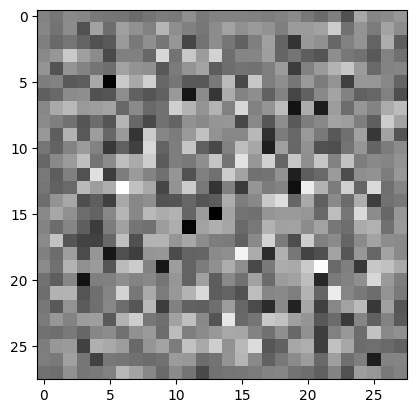

In [12]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [13]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [14]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[-0.00059255]], shape=(1, 1), dtype=float32)


In [15]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [16]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [17]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [18]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [25]:
checkpoint_dir = './desktop/hw5'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [20]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [22]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [23]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as you go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

In [24]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

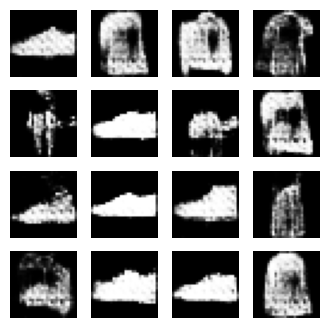

In [26]:
train(train_dataset2, EPOCHS)

In [27]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [28]:
# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

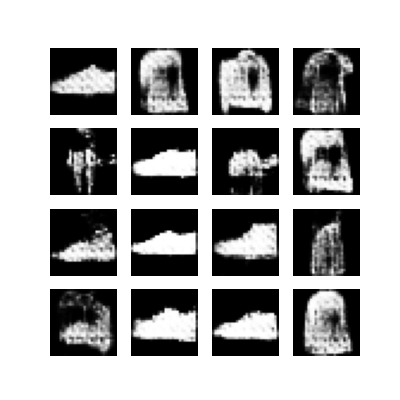

In [29]:
display_image(EPOCHS)

In [40]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

/var/folders/h1/w78ck2d92ql_klkz970v0rhc0000gn/T/ipykernel_25563/1982054950.py:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)
/var/folders/h1/w78ck2d92ql_klkz970v0rhc0000gn/T/ipykernel_25563/1982054950.py:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)



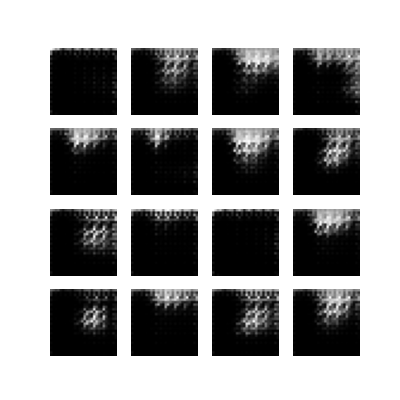

In [39]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)

**Project Progress Report**

Currently, I'm still reading papers about the CNN in identifying the x-ray image field. (https://pubs.rsna.org/doi/full/10.1148/radiol.2018180547, https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0265949 ). I would probably use the similar hyperparameter like in the these papers. Furthermore, I'm done looking for the dataset from kaggle now, I started the data exploratory analysis, I'm looking for more interesting ways to present my data (such as adding more graph).